In [38]:
import logging
import os
import sys
from glob import glob
import tempfile

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
)
from monai.visualize import plot_2d_or_3d_image

from natsort import natsorted


In [1]:
    path_to_grey_img = r"C:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\greyscale"
    path_to_grey_seg = r"C:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\greyscale_out"

    images = natsorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
    segs = natsorted(glob(os.path.join(path_to_grey_seg, "I0*.tiff")))
    #segs = sorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
    #images = sorted(glob(os.path.join(tempdir, "img*.png")))
    #segs = sorted(glob(os.path.join(tempdir, "seg*.png")))

    size = 20 #orig at 20
    train_files = [{"img": img, "seg": seg}
                   for img, seg in zip(images[:size], segs[:size])]
    val_files = [{"img": img, "seg": seg}
                 for img, seg in zip(images[-size:], segs[-size:])]

    # define transforms for image and segmentation
    train_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            RandCropByPosNegLabeld(
                keys=["img", "seg"], label_key="seg", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
            ),
            RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )
    val_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )

    # define dataset, data loader
    check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    check_loader = DataLoader(check_ds, batch_size=2,
                              num_workers=0, collate_fn=list_data_collate)
    check_data = monai.utils.misc.first(check_loader)
    print(check_data["img"].shape, check_data["seg"].shape)




NameError: name 'natsorted' is not defined

['C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale\\IMG00000_01.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale\\IMG00000_02.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale\\IMG00000_03.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale\\IMG00000_04.tiff']
['C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale_out\\I0_01.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale_out\\I0_02.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale_out\\I0_03.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale_out\\I0_04.tiff']


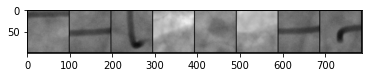

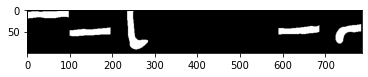

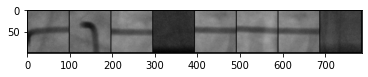

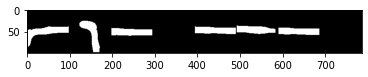

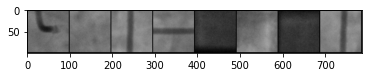

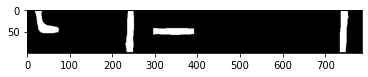

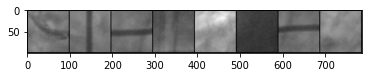

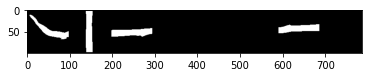

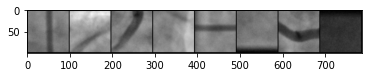

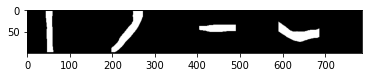

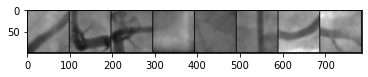

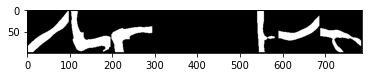

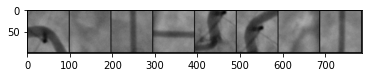

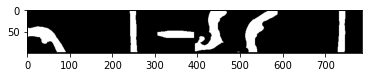

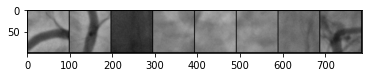

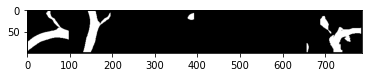

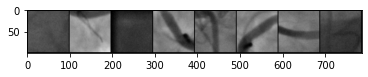

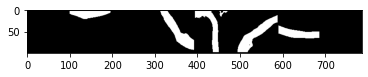

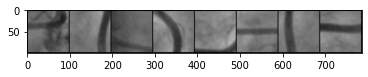

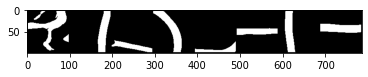

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from natsort import natsorted

test = iter(check_loader)
#img = test.next()
print(images[:4])
print(segs[:4])

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#images2 = natsorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
#segs2 = natsorted(glob(os.path.join(path_to_grey_seg, "I0*.tiff")))

#print(images2[:4])
#print(segs2[:4])

#print(img.keys())
#print(list(img.values())[0])
for i, data in enumerate(test):
  img = data
  imshow(torchvision.utils.make_grid(list(img.values())[0]))
  imshow(torchvision.utils.make_grid(list(img.values())[1]))


In [4]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
)
from monai.visualize import plot_2d_or_3d_image

from natsort import natsorted

def main(tempdir):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # create a temporary directory and 40 random image, mask pairs
    #print(f"generating synthetic data to {tempdir} (this may take a while)")
    #for i in range(40):
    #    im, seg = create_test_image_2d(128, 128, num_seg_classes=1)
    #    Image.fromarray((im * 255).astype("uint8")
    #                    ).save(os.path.join(tempdir, f"img{i:d}.png"))
    #    Image.fromarray((seg * 255).astype("uint8")
    #                    ).save(os.path.join(tempdir, f"seg{i:d}.png"))

    
    #path_to_img = "Z:\dikuAngiograms\Bachelor work\Mads\ImsegmentedPt_02 V_0\Orig"
    #path_to_seg = "Z:\dikuAngiograms\Bachelor work\Mads\ImsegmentedPt_02 V_0\Segmented2\RegUnSharpenedB"

    path_to_grey_img = r"C:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\greyscale"
    path_to_grey_seg = r"C:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\greyscale_out"

    images = natsorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
    segs = natsorted(glob(os.path.join(path_to_grey_seg, "I0*.tiff")))
    #segs = sorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
    #images = sorted(glob(os.path.join(tempdir, "img*.png")))
    #segs = sorted(glob(os.path.join(tempdir, "seg*.png")))

    size = 20 #orig at 20
    train_files = [{"img": img, "seg": seg}
                   for img, seg in zip(images[:size], segs[:size])]
    val_files = [{"img": img, "seg": seg}
                 for img, seg in zip(images[-size:], segs[-size:])]

    # define transforms for image and segmentation
    train_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            RandCropByPosNegLabeld(
                keys=["img", "seg"], label_key="seg", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
            ),
            RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )
    val_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )

    # define dataset, data loader
    check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    check_loader = DataLoader(check_ds, batch_size=2,
                              num_workers=0, collate_fn=list_data_collate)
    check_data = monai.utils.misc.first(check_loader)
    print(check_data["img"].shape, check_data["seg"].shape)


    # create a training data loader
    train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    train_loader = DataLoader(
        train_ds,
        batch_size=2,
        shuffle=True,
        num_workers=0,
        collate_fn=list_data_collate,
        pin_memory=torch.cuda.is_available(),
    )
    # create a validation data loader
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1,
                            num_workers=0, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=True,
                             reduction="mean", get_not_nans=False)
    post_trans = Compose([EnsureType(), Activations(
        sigmoid=True), AsDiscrete(threshold=0.5)]) #threshold 0.5
    # create UNet, DiceLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    loss_function = monai.losses.DiceLoss(sigmoid=True) #smooth_nr = 0, smooth_dr = 1e-5,
    # DiceLoss(sigmoid=True)
    #loss_function = monai.losses.DiceFocalLoss(sigmoid=True, focal_weight=27)
        #TverskyLoss(
        #to_onehot_y=False, sigmoid=True, include_background=True,beta=27)
                                 #         squared_pred=True, to_onehot_y=False, sigmoid=True)  # DiceLoss(sigmoid=True, include_background=True, squared_pred=True)

    optimizer = torch.optim.Adam(model.parameters(), 0.01)#1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    writer = SummaryWriter()
    for epoch in range(100):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["img"].to(
                device), batch_data["seg"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(),
                              epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data["img"].to(
                        device), val_data["seg"].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(
                        val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i)
                                   for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)
                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(),
                               "best_metric_model_segmentation2d_dict.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1,
                                    writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1,
                                    writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1,
                                    writer, index=0, tag="output")

    print(
        f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()


if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tempdir:
        main(tempdir)


MONAI version: 0.8.0
Numpy version: 1.19.3
Pytorch version: 1.10.2+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.2
Pillow version: 8.0.1
Tensorboard version: 2.8.0
gdown version: 4.3.1
TorchVision version: 0.11.3+cpu
tqdm version: 4.60.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.1.4
einops version: 0.4.0
transformers version: 4.16.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

torch.Size([8, 1, 96, 96]) torch.Size([8, 1, 96, 96])
----------
epoch 1/10
1/10, train_loss: 0.9193
2/10, train_loss: 0.8300
3/10, train_loss: 0.8772
4/10, train_loss: 0.8014
5/10, train_loss: 0.7682
6/10, train_loss: 0.8102
7/10, train_loss: 0.9091
8/10, train_

In [5]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import Activations, AddChanneld, AsDiscrete, Compose, LoadImaged, SaveImage, ScaleIntensityd, EnsureTyped, EnsureType

from natsort import natsorted


def main(tempdir):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    #print(f"generating synthetic data to {tempdir} (this may take a while)")
    #for i in range(5):
    #    im, seg = create_test_image_2d(128, 128, num_seg_classes=1)
    #    Image.fromarray((im * 255).astype("uint8")
    #                    ).save(os.path.join(tempdir, f"img{i:d}.png"))
    #    Image.fromarray((seg * 255).astype("uint8")
    #                    ).save(os.path.join(tempdir, f"seg{i:d}.png"))

    #images = sorted(glob(os.path.join(tempdir, "img*.png")))
    #segs = sorted(glob(os.path.join(tempdir, "seg*.png")))

    path_to_grey_img = r"C:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\greyscale"
    path_to_grey_seg = r"C:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\greyscale_out"

    images = natsorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
    segs = natsorted(glob(os.path.join(path_to_grey_seg, "I0*.tiff")))

    val_files = [{"img": img, "seg": seg} for img, seg in zip(images, segs)]

    # define transforms for image and segmentation
    val_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    # sliding window inference need to input 1 image in every iteration
    val_loader = DataLoader(val_ds, batch_size=1,
                            num_workers=0, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=True,
                             reduction="mean", get_not_nans=False)
    post_trans = Compose([EnsureType(), Activations(
        sigmoid=True), AsDiscrete(threshold=0.1)])
    saver = SaveImage(output_dir="./output",
                      output_ext=".png", output_postfix="seg")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    model.load_state_dict(torch.load(
        "best_metric_model_segmentation2d_dict.pth"))

    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            val_images, val_labels = val_data["img"].to(
                device), val_data["seg"].to(device)
            # define sliding window size and batch size for windows inference
            roi_size = (96, 96)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(
                val_images, roi_size, sw_batch_size, model)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            val_labels = decollate_batch(val_labels)
            # compute metric for current iteration
            dice_metric(y_pred=val_outputs, y=val_labels)
            for val_output in val_outputs:
                saver(val_output)
        # aggregate the final mean dice result
        print("evaluation metric:", dice_metric.aggregate().item())
        # reset the status
        dice_metric.reset()


if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tempdir:
        main(tempdir)


MONAI version: 0.8.0
Numpy version: 1.19.3
Pytorch version: 1.10.2+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.2
Pillow version: 8.0.1
Tensorboard version: 2.8.0
gdown version: 4.3.1
TorchVision version: 0.11.3+cpu
tqdm version: 4.60.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.1.4
einops version: 0.4.0
transformers version: 4.16.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

file written: c:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\output\0\0_seg.png.
file written: c:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\output\1\1_seg.png.
file written: c:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\output\2\2_seg.png.
file written: 

In [6]:
path_to_grey_img = r"C:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\greyscale"
path_to_grey_seg = r"C:\Users\Mads Syge Monster PC\Desktop\pythonDUmp\greyscale_out"

images = natsorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
segs = natsorted(glob(os.path.join(path_to_grey_seg, "I0*.tiff")))

val_files = [{"img": img, "seg": seg} for img, seg in zip(images, segs)]

# define transforms for image and segmentation
val_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        AddChanneld(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        EnsureTyped(keys=["img", "seg"]),
    ]
)
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
# sliding window inference need to input 1 image in every iteration
val_loader = DataLoader(val_ds, batch_size=1,
                        num_workers=0, collate_fn=list_data_collate)


['C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale\\IMG00000_01.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale\\IMG00000_02.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale\\IMG00000_03.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale\\IMG00000_04.tiff']
['C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale_out\\I0_01.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale_out\\I0_02.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale_out\\I0_03.tiff', 'C:\\Users\\Mads Syge Monster PC\\Desktop\\pythonDUmp\\greyscale_out\\I0_04.tiff']


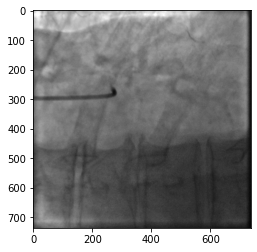

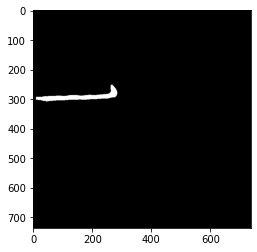

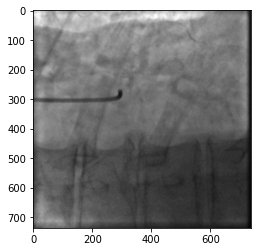

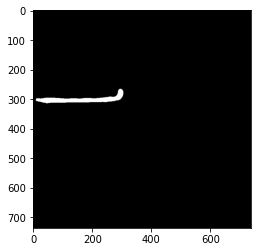

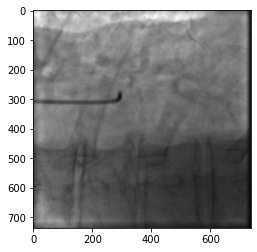

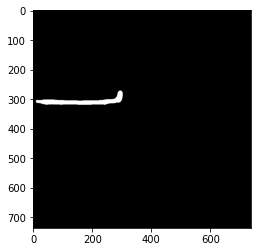

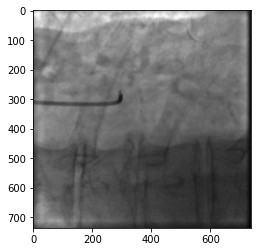

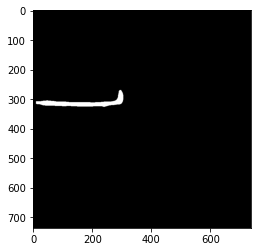

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from natsort import natsorted

test = iter(val_loader)
#img = test.next()
print(images[:4])
print(segs[:4])


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#images2 = natsorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
#segs2 = natsorted(glob(os.path.join(path_to_grey_seg, "I0*.tiff")))

#print(images2[:4])
#print(segs2[:4])


#print(img.keys())
#print(list(img.values())[0])
for i, data in enumerate(test):
  img = data
  imshow(torchvision.utils.make_grid(list(img.values())[0]))
  imshow(torchvision.utils.make_grid(list(img.values())[1]))
  if (i == 3):
    break


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(
    "best_metric_model_segmentation2d_dict.pth"))

model.eval()


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

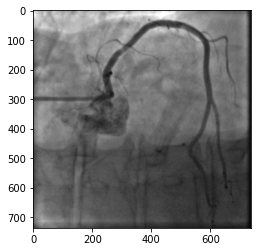

[[[[7.27516366e-04 9.06283458e-06 1.03955535e-05 ... 9.99987841e-01
    9.99982476e-01 9.98097241e-01]
   [4.31553453e-05 5.73378941e-07 5.57955140e-08 ... 1.00000000e+00
    1.00000000e+00 9.99994278e-01]
   [2.57250449e-05 1.63812189e-07 2.11330780e-06 ... 1.00000000e+00
    1.00000000e+00 9.99998212e-01]
   ...
   [8.62778842e-01 9.70780313e-01 8.99294734e-01 ... 1.00000000e+00
    1.00000000e+00 1.00000000e+00]
   [5.43946505e-01 6.51882291e-01 5.26007652e-01 ... 1.00000000e+00
    1.00000000e+00 9.99999166e-01]
   [2.11116463e-01 2.85152733e-01 1.76522434e-01 ... 9.99999762e-01
    9.99996781e-01 9.99724329e-01]]]]


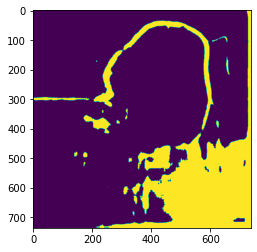

In [39]:
val_iter = iter(val_loader)
img = val_iter.next()
for i in range(30):
  img = val_iter.next()
imshow(torchvision.utils.make_grid(list(img.values())[0]))

res = model(list(img.values())[0])

#tensor.detach().numpy()
res_np = (torch.sigmoid(res)).detach().numpy()
_, pred = torch.max(res, 1)


#print(torch.sigmoid(res))

#print(torch.max(res,1))
print(res_np)

res_np[0][0].shape
plt.figure()
plt.imshow(res_np[0][0]>0.9)
#plt.imshow(pred.detach().numpy()[0])
